## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
from matplotlib import pyplot as plt


In [2]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

In [3]:
def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']  # Load MATLAB file
    return data[2:]  

In [4]:
def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)  

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


In [5]:
def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    
    return (AggregateErrorMetric(errs, confs), errs, confs)

In [6]:
def BandpassFilter(signal, pass_band, fs):
    """
    Passes a signal through a butterworth filter. 
    Args:
    signal: signal from sensors
    pass_band: (tuple) The pass band. Frequency components outside the two elements in the tuple will be removed.
    fs: the sampling frequency of the digital system.

    Returns:
        Bandpass filtered signal
    """      
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


In [7]:
def fourier_transform(signal, fs):
    """
    Run a Fourier Transform on a signal
    
    Returns:
        Freq and Magnitude of the signal after running the FFT
    """
    freqs = np.fft.rfftfreq(len(signal), 1/fs)
    fft = np.abs(np.fft.rfft(signal))

    return freqs, fft

In [8]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    
    Args:
    data_fl: (str) filepath to a troika .mat file.
    ref_fl: (str) filepath to a troika .mat file (reference file. the ground-truth of heart rate)
    
    Returns:
    pr_errors: a numpy array of errors between pulse rate estimates and
        corresponding reference heart rates.
    confidence_est: a numpy array of confidence estimates for each pulse
        rate error.
    
    """ 
    fs = 125
    pass_band = (40/60.0, 240/40.0)
    
    #load ground-truth of heart rate
    ref_hrs = sp.io.loadmat(ref_fl)['BPM0']
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    acc = np.mean([accx, accy, accz], axis=0)
    data_list = [ppg, acc]
    label_list = ['ppg', 'acc']
    
    # Bandpass filter the signal between 40 and 240 Herz
    filtered = {label: BandpassFilter(data, pass_band, fs) for (
        label, data) in zip(label_list, data_list)}

    # Move with a window_length_s of 8s and the window_shift_s of 2s
    # The ground truth data follows the same cadence
    errors, confidence = [], []
    window_length_s = 8
    window_shift_s = 2
    window_length = window_length_s * fs
    window_shift = window_shift_s * fs    
    for i in range(0, len(ppg) - window_length, window_shift):
        segments = {label: filtered[label][i: i + window_length] for label in label_list}

        freqs, fft, sorted_inds, sorted_freqs = {}, {}, {}, {}
        for label in label_list:
            freqs[label], fft[label] = fourier_transform(segments[label], fs)
            sorted_inds[label] = np.argsort(fft[label])[::-1][:4]
            sorted_freqs[label] = freqs[label][sorted_inds[label]]

        try:
            est_f = [freq for freq in sorted_freqs['ppg']
                     if freq not in sorted_freqs['acc']][0]

        except:
            ind = sorted_inds['ppg'][0]
            est_f = freqs['ppg'][ind]

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    idx = list(range(0, len(ppg) - window_length, window_shift))   
    est_hr = est_f * 60
    ref_hr = ref_hrs[idx.index(i)][0]
    errors.append(np.mean(np.abs(est_hr-ref_hr)))
    confidence.append(np.sum(fft['ppg'][(freqs['ppg'] >= est_f-30/60) & (
    freqs['ppg'] <= est_f+30/60)]) / np.sum(fft['ppg']))
    errors = np.array(errors) 
    confidence = np.array(confidence)
  
    return errors, confidence

In [25]:
metric, errs, confs = Evaluate()
metric, errs, confs

(3.8366888498402618,
 array([  3.27922078,   7.29321315,   0.9238    ,   1.768     ,
          4.2117    ,   0.1023    ,  10.5612    ,   1.7571885 ,
          2.4972    ,   4.4104    ,   8.6392    ,   3.4959    ]),
 array([ 0.3011231 ,  0.32099231,  0.34371562,  0.37347262,  0.46265377,
         0.35763933,  0.45579208,  0.4258242 ,  0.39691609,  0.4702064 ,
         0.32689506,  0.47725692]))

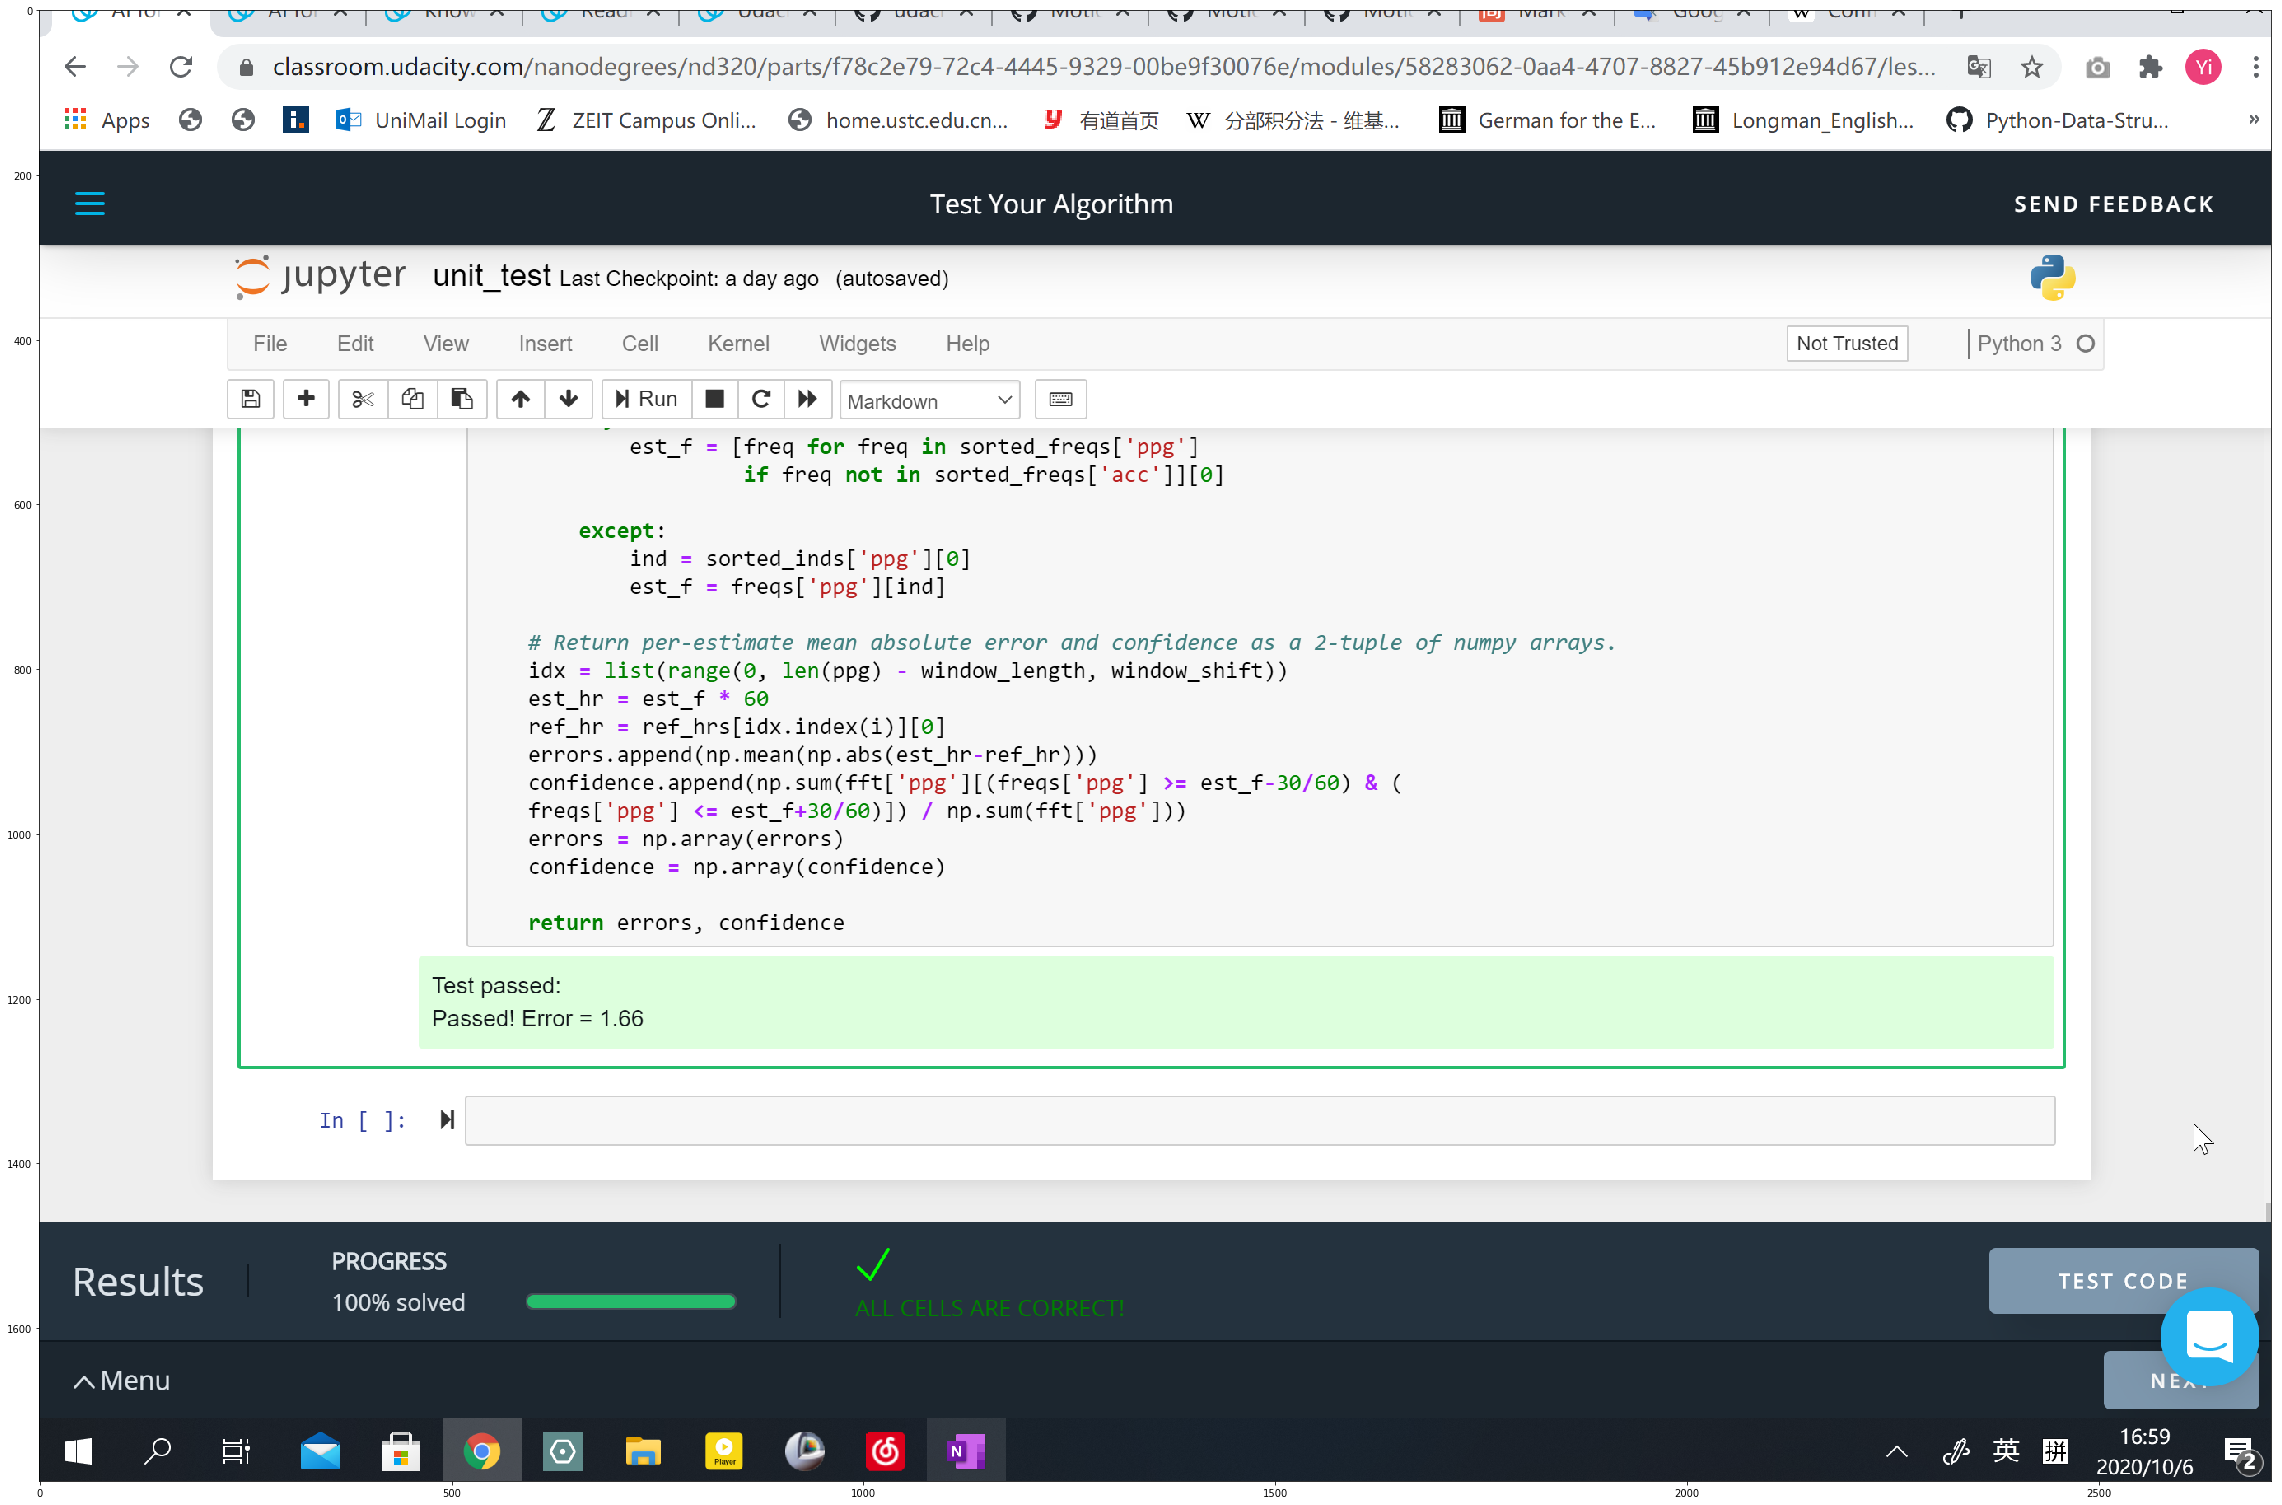

In [27]:
import matplotlib.image as mpimg
img=mpimg.imread('passed.png')
plt.figure(figsize=(40,40))
plt.imshow(img)
plt.show()

In [11]:
data_fls, ref_fls = LoadTroikaDataset()
data_fls, ref_fls

(['./datasets/troika/training_data/DATA_01_TYPE01.mat',
  './datasets/troika/training_data/DATA_02_TYPE02.mat',
  './datasets/troika/training_data/DATA_03_TYPE02.mat',
  './datasets/troika/training_data/DATA_04_TYPE01.mat',
  './datasets/troika/training_data/DATA_04_TYPE02.mat',
  './datasets/troika/training_data/DATA_05_TYPE02.mat',
  './datasets/troika/training_data/DATA_06_TYPE02.mat',
  './datasets/troika/training_data/DATA_07_TYPE02.mat',
  './datasets/troika/training_data/DATA_08_TYPE02.mat',
  './datasets/troika/training_data/DATA_10_TYPE02.mat',
  './datasets/troika/training_data/DATA_11_TYPE02.mat',
  './datasets/troika/training_data/DATA_12_TYPE02.mat'],
 ['./datasets/troika/training_data/REF_01_TYPE01.mat',
  './datasets/troika/training_data/REF_02_TYPE02.mat',
  './datasets/troika/training_data/REF_03_TYPE02.mat',
  './datasets/troika/training_data/REF_04_TYPE01.mat',
  './datasets/troika/training_data/REF_04_TYPE02.mat',
  './datasets/troika/training_data/REF_05_TYPE02.mat

In [12]:
np.shape(sp.io.loadmat(data_fls[0])['sig'])

(6, 37937)

In [13]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
ppg, accx, accy, accz

(array([   4. ,    6. ,    3. , ...,   86. ,  104. ,  118.5]),
 array([-0.0702, -0.0702, -0.0546, ...,  0.4134,  0.4134,  0.4134]),
 array([ 0.3432,  0.3588,  0.3666, ..., -0.2808, -0.273 , -0.273 ]),
 array([ 0.9594,  0.9438,  0.936 , ...,  0.7254,  0.7176,  0.7254]))

In [14]:
np.shape(ppg)

(37937,)

In [15]:
len(ppg)

37937

In [16]:
ecg=sp.io.loadmat(ref_fls[0])
ecg

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 12 01:00:33 2014',
 '__version__': '1.0',
 '__globals__': [],
 'BPM0': array([[  74.33920705],
        [  76.35746606],
        [  77.14285714],
        [  74.66814159],
        [  72.58064516],
        [  71.68458781],
        [  72.89416847],
        [  73.44940152],
        [  75.33482143],
        [  76.8442623 ],
        [  79.5990566 ],
        [  79.11392405],
        [  74.50331126],
        [  70.83825266],
        [  69.58762887],
        [  71.94244604],
        [  77.31958763],
        [  80.29978587],
        [  82.87292818],
        [  83.51893096],
        [  84.65011287],
        [  88.23529412],
        [  90.95920617],
        [  92.87925697],
        [  94.73684211],
        [  97.28773585],
        [  99.66777409],
        [ 101.58013544],
        [ 102.84810127],
        [ 103.44827586],
        [ 103.17460317],
        [ 102.95670539],
        [ 103.28389831],
        [ 104.05549626],
   

In [17]:
ecg_array=ecg['BPM0']
ecg_array

array([[  74.33920705],
       [  76.35746606],
       [  77.14285714],
       [  74.66814159],
       [  72.58064516],
       [  71.68458781],
       [  72.89416847],
       [  73.44940152],
       [  75.33482143],
       [  76.8442623 ],
       [  79.5990566 ],
       [  79.11392405],
       [  74.50331126],
       [  70.83825266],
       [  69.58762887],
       [  71.94244604],
       [  77.31958763],
       [  80.29978587],
       [  82.87292818],
       [  83.51893096],
       [  84.65011287],
       [  88.23529412],
       [  90.95920617],
       [  92.87925697],
       [  94.73684211],
       [  97.28773585],
       [  99.66777409],
       [ 101.58013544],
       [ 102.84810127],
       [ 103.44827586],
       [ 103.17460317],
       [ 102.95670539],
       [ 103.28389831],
       [ 104.05549626],
       [ 106.20915033],
       [ 108.58324716],
       [ 110.66969353],
       [ 111.58342189],
       [ 112.29946524],
       [ 112.78195489],
       [ 113.63636364],
       [ 114.503

In [18]:
len(ecg_array)

148

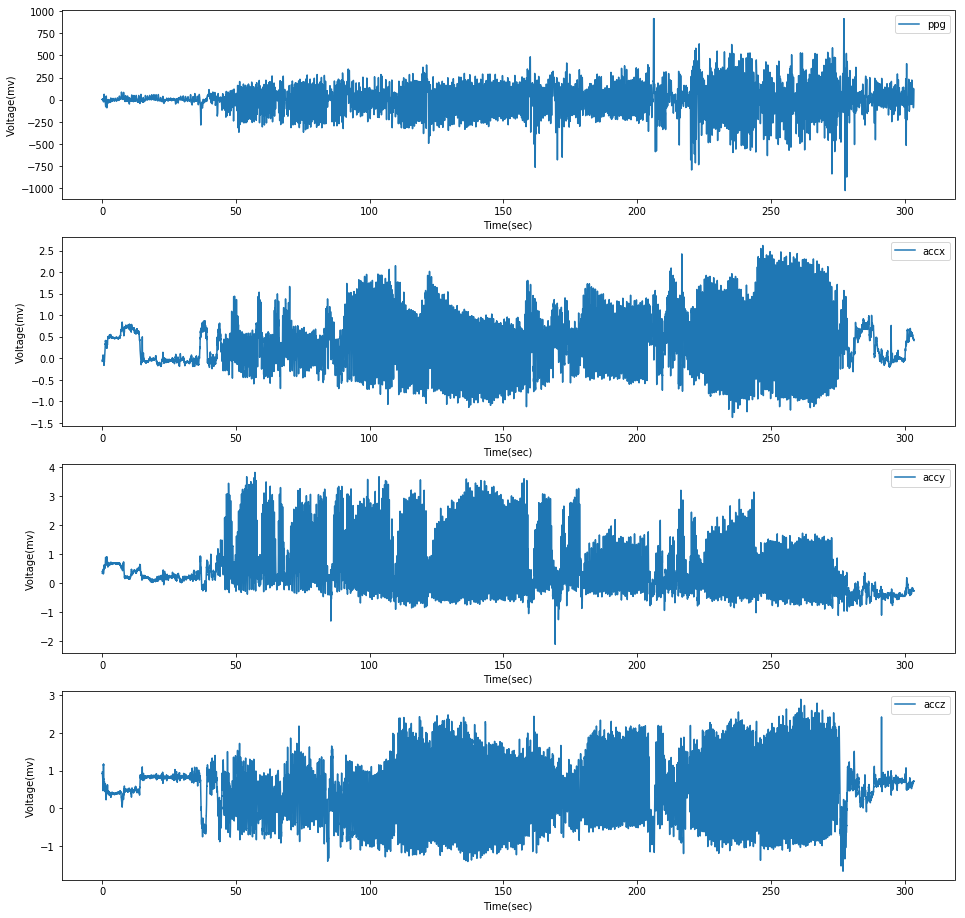

In [19]:
from matplotlib import pyplot as plt
fs=125
ts=np.arange(len(ppg))/fs

data_list = [ppg, accx, accy, accz]
label_list = ['ppg', 'accx', 'accy', 'accz']
figs, axes = plt.subplots(4, figsize=(16, 16))
for val, num in enumerate(axes):
    axes[val].plot(ts, data_list[val], label = label_list[val])
    axes[val].legend(loc='upper right')
    axes[val].set_ylabel('Voltage(mv)')
    axes[val].set_xlabel('Time(sec)')


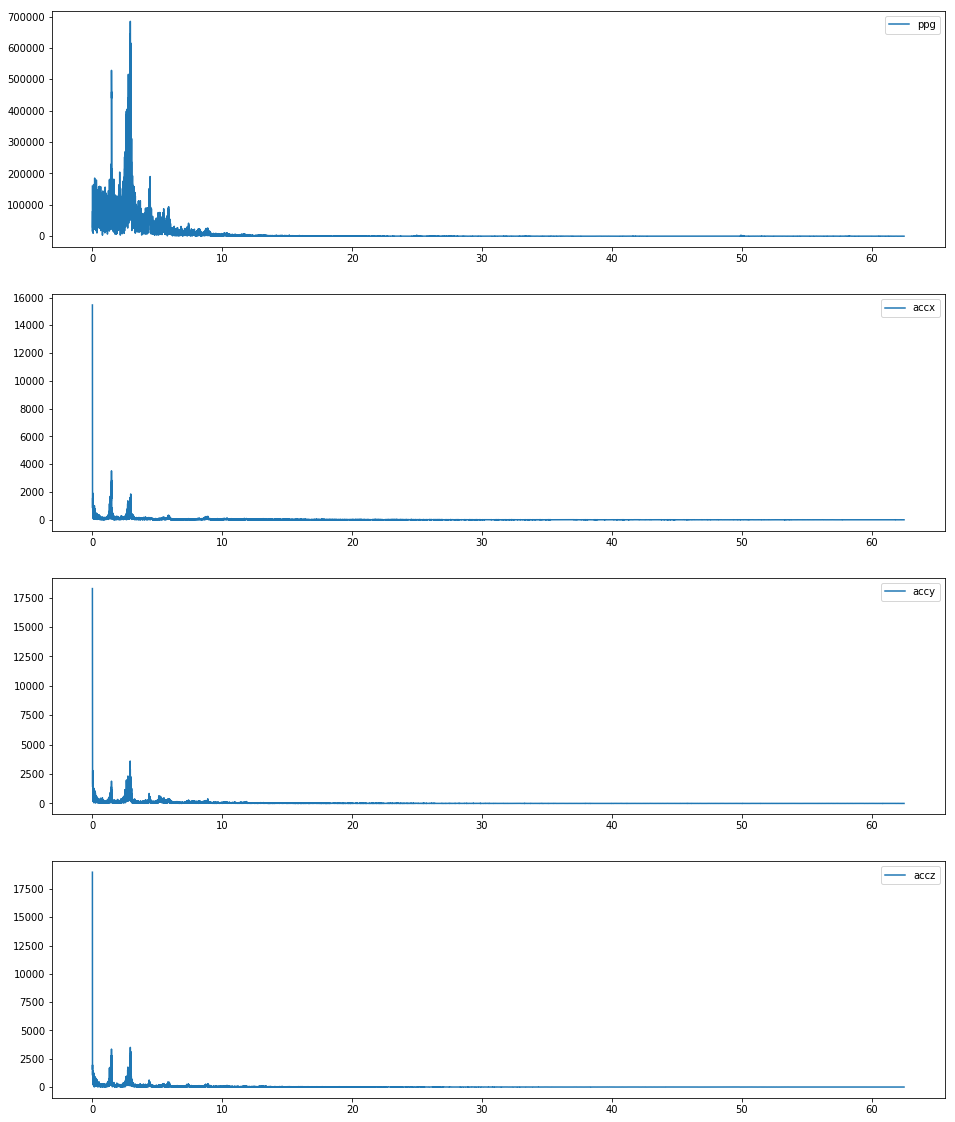

In [20]:
figs, axes = plt.subplots(4, figsize=(16, 20))
for val, num in enumerate(axes):
    freqs, fft = fourier_transform(data_list[val], fs)
    axes[val].plot(freqs, fft, label = label_list[val])
    axes[val].legend(loc='upper right')


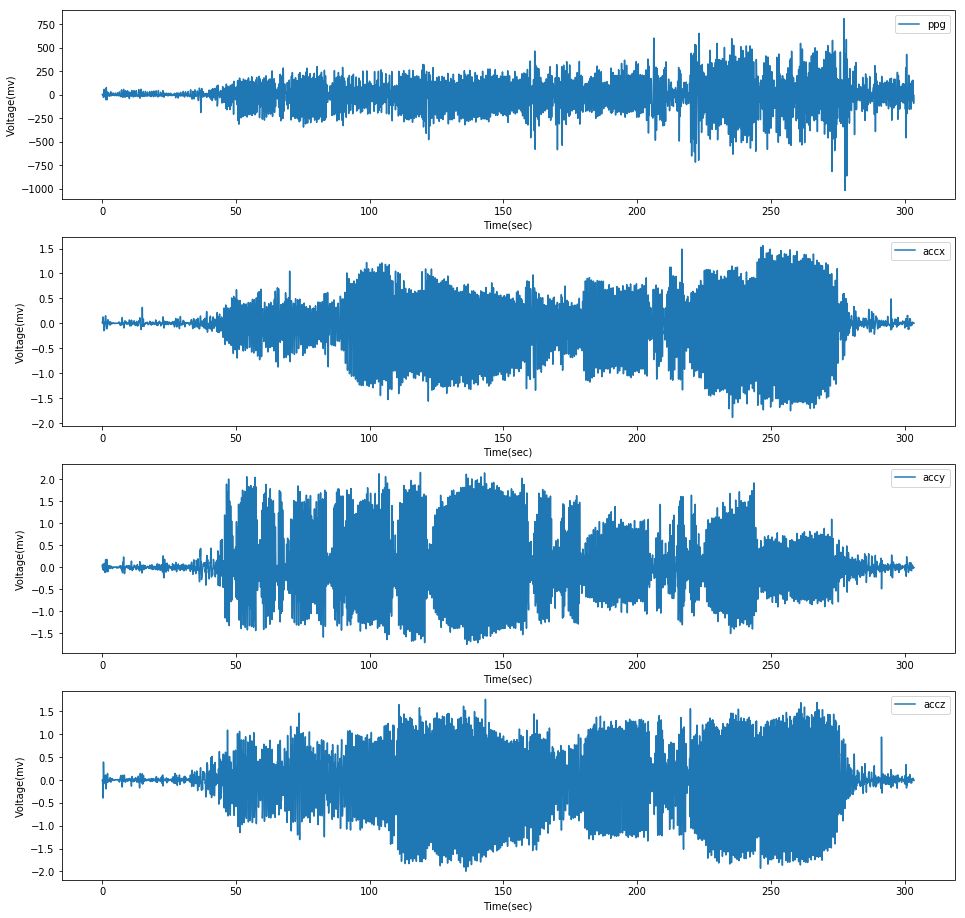

In [21]:
figs, axes = plt.subplots(4, figsize=(16, 16))
pass_band = pass_band = (40/60.0, 240/40.0)
for val, num in enumerate(axes):
    fsig=BandpassFilter(data_list[val], pass_band, fs)  # filtered signal
    axes[val].plot(ts, fsig, label = label_list[val])
    axes[val].legend(loc='upper right')
    axes[val].set_ylabel('Voltage(mv)')
    axes[val].set_xlabel('Time(sec)')




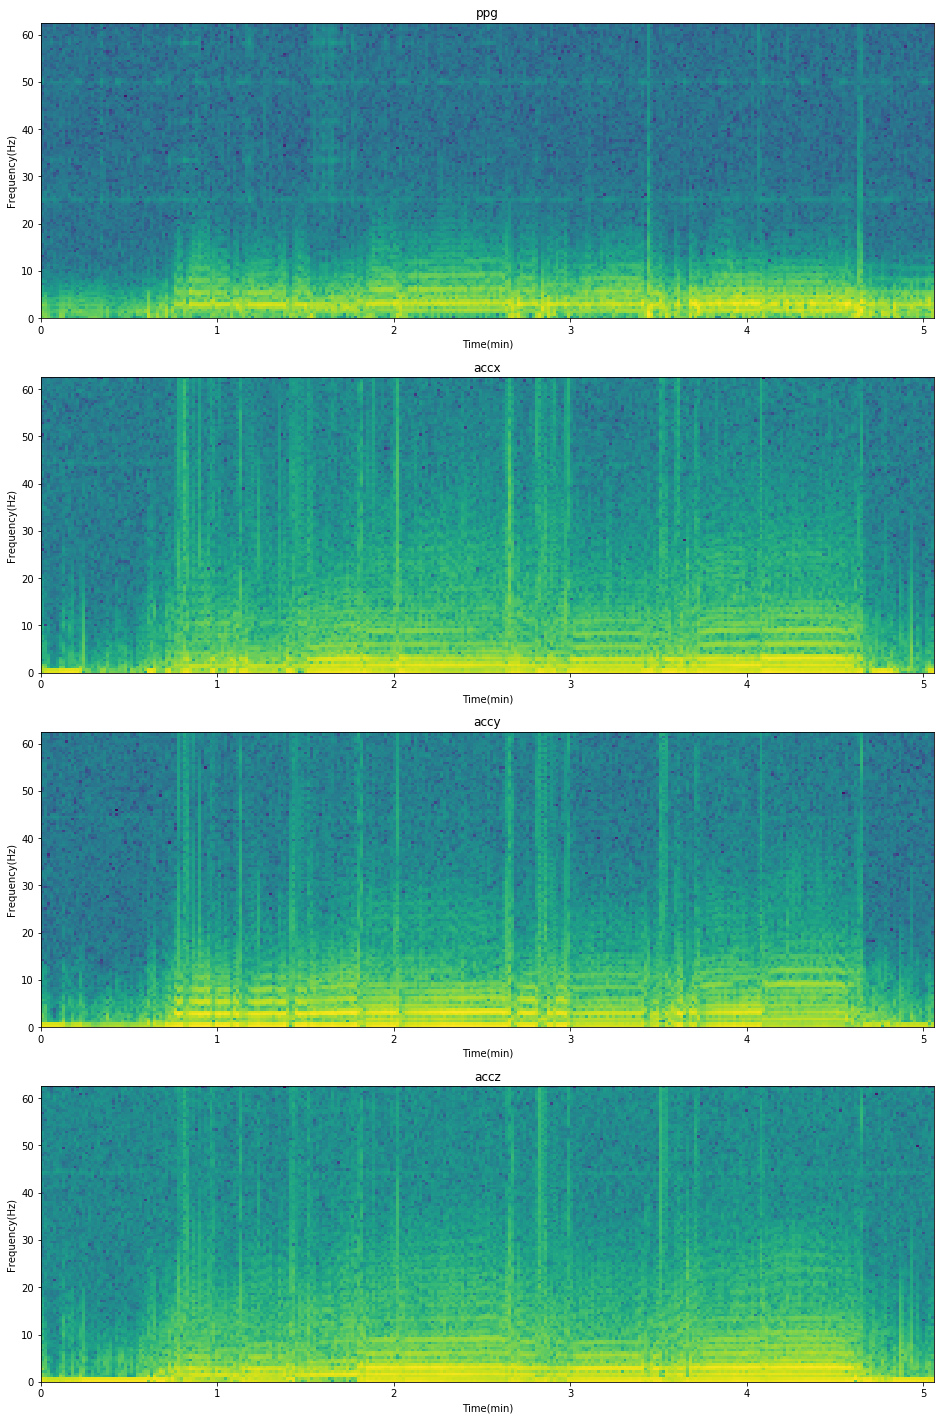

In [22]:
figs, axes = plt.subplots(4, figsize=(16, 25))
for val, num in enumerate(axes):
    axes[val].specgram(data_list[val],Fs=fs,NFFT=250,noverlap=125,xextent=[0,len(data_list[val])/fs/60])
    axes[val].set_ylabel('Frequency(Hz)')
    axes[val].set_xlabel('Time(min)')
    axes[val].set_title(label_list[val])


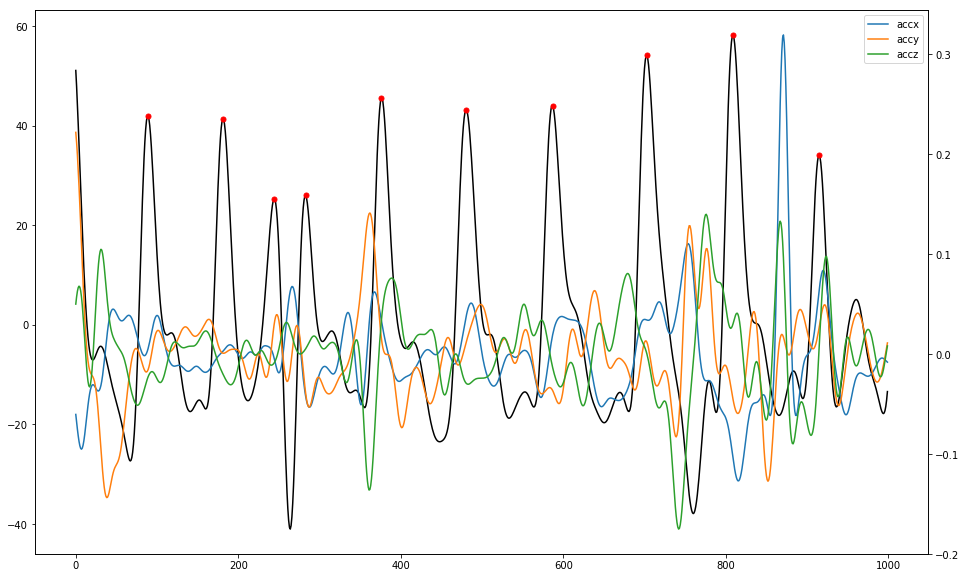

In [24]:
pass_band = pass_band = (40/60.0, 240/40.0)
fsig = {label : BandpassFilter(data, pass_band, fs) for (label, data) in zip(label_list, data_list)}
ppg_seg = fsig['ppg'][1000:2000]
pks=sp.signal.find_peaks(ppg_seg,height=15,distance=35)[0]

fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()

ax1.plot(ppg_seg, 'black')
ax1.plot(pks, ppg_seg[pks], 'r.', ms=10)

for label in label_list[1:]:
    ax2.plot(fsig[label][1000:2000], label=label)
    ax2.legend(loc='upper right')

plt.show()




-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

- **Code Description**
   Run the code cell below to check the performance of the algorithm on the training data.
This code is used to estimate the pulse rate from PPG signal and a 3-axis accelerometer. It includes seven functions, where:

 * LoadTroikaDataset() function is used to give the data path of all files.
 * LoadTroikaDataFile(data_fl) function is used to load the numpy array of signals of each file.
 * BandpassFilter(signal, pass_band, fs) is used to filter the signal  according to the value of pass_band. In this algorithm our signals are filtered between 40BPM and 240BPM.
 * fourier_transform(signal, fs) is fourier transform,  by runing this function we can get discrete fourier transform(DFT) sample frequencies and the real-valued array of DFT.
 * AggregateErrorMetric(pr_errors, confidence_est) is used to compute the mean absolute error (MAE) according to given confidence interval.
 * RunPulseRateAlgorithm(data_fl, ref_fl) uses a 8 second non-overlapping window to divide signals and each window is 2s(to produces an output every 2 seconds) to generate features that we needed (confidence estimates for each pulse rate error and errors between pulse rate estimates).
 * Evaluate() load first the TROIKA data and reference files. And then run the RunPulseRateAlgorithm function to estimate the errors and their corresponding confidence. It can return the MAE of the dataset.

   To run the result of this project and get the metric. We only need to run the Evaluate() function.

**Data Description**
* what activities were performed in the dataset:
  * According to the introduce of this dataset, we know that each subject ran on a treadmill with changing speeds(for example rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)). The activities are perhaps jog and run and of course rest at various speeds

* features of the sensor that was used:
  * ECG sensor generated signals with one channel. 
  * PPG sensor generated signals with two channel. 
  * The accelerometer generated signals with three channels (x, y and z). 
  * ECG signals is used as reference heart rate(ground truth) and the other two kind of signals are used to handle our heart rate estimation.

* the quantity of data in the dataset: 
  * This dataset is 125Hz sampled from 12 different subjects. 
  * Each subject contains a variable 'sig'. It has 6 rows. The first row is a simultaneous recording of ECG. The second row and the third row are two channels of PPG. The last three rows are simultaneous recordings of acceleration data (in x-, y-, and z-axis). 

* short-comings of the dataset. 
  * This dataset contains only 12 subjects. Therefore the number of samples is not large enough to get a stable and reliable result. 
  * This dataset is collected from subject of age 18 - 35 years old. So the result based on this dataset is only suitable for people in the age of 18-35. 
  * And there are no gender information about this dataset.

**Algorithhm Description** will include the following:
* how the algorithm works:
   * Assign the path of all files and load the data in 'sig' for each file.
   * The pulse signal is restrictedbetween 40BPM and 240BPM to match with the real-life by using Bandpass.
   * Divide the signal into smaller windows of 8s, each window separated by 2s.
   * Use Fast Fourier Transformation to get the DFT sample frequencies and the corresponding magnitude.
   * Using of the given windows and the result of fourier transformation function to get sorted data and find the strongest frequeny from the PPG data.
   * Choose the correct pulse to estimate our heart rate for that window.
   * Compute the confidence of the estimated heart rat and the errors between PPG and ECG signals.
   * Compute the MAE by using the confidence and errors.

* the specific aspects of the physiology that it takes advantage of:
   * The PPG sensor is usually used to estimate the pulse rate. When the ventricles contract, the capillaries in the wrist fill with blood. The (usually green) light emitted by the PPG sensor is absorbed by the red blood cells in these capillaries, and the photodetector will see a drop in the reflected light. When the blood returns to the heart, the red blood cells in the wrist will absorb less light, and the photodetector will see an increase in reflected light.

* a describtion of the algorithm outputs:
   * the MAE at 90% availability
   * errors between pulse rate estimates and corresponding reference heart rates
   * the confidence score of that prediction. The confidence algorithm sums the frequency magnitude around the estimated pulse rate, and then divides it by the sum of the entire magnitudes to produce higher numbers for better estimates.

* caveats on algorithm outputs:
   * The confidence rate is calculated based only on the magnitude of a small region containing the estimated spectrum frequency relative to the total amplitude of the entire spectrum.

* common failure modes
   * Sometimes the cadence of the arm swing is the same as the heartbeat.

**Algorithm Performance** 
   * The metric used to compute the error is Mean Absolute Error(MAE). It computes the mean absolute error between the estimated heart rate and the reference heart rate at 90% availability.
   * The error of the model in the testing data is 1.66.
   * There is a trade-off between availability and error. For example, if we want to operate at 90% availability, we look at our training dataset to determine the confidence threshold for which 90% of the estimates pass. Then if only if an estimate's confidence value is above that threshold, do we consider it valid.
   

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 